# Trabajo Práctico 5 Aprendizaje de Máquina  

Alumno: Leandro Borgnino

Profesores:
- Claudio Delrieux
- Manlio Miguel Massiris

## Consigna Trabajo Práctico  
Este trabajo práctico busca aplicar algoritmos de clustering en un dataset de estadísticas de jugadores de fútbol del juego FIFA2022. La idea es poder agrupar jugadores en base a sus habilidades. La hipótesis a priori es que según las habilidades la agrupación debiera ser similar a la posición en la que juegan en sus clubes. Además, como extra se usará como información su valoración para determinar qué es lo que valoriza en mayor medida a un jugador.


### 1. Importar librerías

In [270]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io

In [271]:
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns

In [272]:
from sklearn import cluster, decomposition, preprocessing
from sklearn.cluster import KMeans, MeanShift, AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

### 2. Exploración de la base de datos 
La base de datos fue extraída de: https://www.kaggle.com/cashncarry/fifa-22-complete-player-dataset?select=players_fifa22.csv

In [273]:
!wget "https://drive.google.com/uc?export=download&id=1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx" -O data.csv

--2021-11-05 18:30:35--  https://drive.google.com/uc?export=download&id=1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx
Resolving drive.google.com (drive.google.com)... 108.177.96.138, 108.177.96.100, 108.177.96.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.96.138|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f8gpa0012ll11le8fhm99oak6p40jiue/1636137000000/04192308875186957499/*/1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx?e=download [following]
--2021-11-05 18:30:37--  https://doc-10-4k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f8gpa0012ll11le8fhm99oak6p40jiue/1636137000000/04192308875186957499/*/1YbHoR0qA66l5dhe6Keal7w3tI8VevTEx?e=download
Resolving doc-10-4k-docs.googleusercontent.com (doc-10-4k-docs.googleusercontent.com)... 142.250.145.132, 2a00:1450:4013:c14::84
Connecting to doc-10-4k-docs.googleusercontent.com (doc-1

In [274]:
df=pd.read_csv("data.csv")
df.head(4)

ID               Name                      FullName  Age  Height  \
0  158023           L. Messi                  Lionel Messi   34     170   
1  188545     R. Lewandowski            Robert Lewandowski   32     185   
2   20801  Cristiano Ronaldo  C. Ronaldo dos Santos Aveiro   36     187   
3  231747          K. Mbappé                 Kylian Mbappé   22     182   

   Weight                                          PhotoUrl Nationality  \
0      72  https://cdn.sofifa.com/players/158/023/22_60.png   Argentina   
1      81  https://cdn.sofifa.com/players/188/545/22_60.png      Poland   
2      83  https://cdn.sofifa.com/players/020/801/22_60.png    Portugal   
3      73  https://cdn.sofifa.com/players/231/747/22_60.png      France   

   Overall  Potential  Growth  TotalStats  BaseStats Positions BestPosition  \
0       93         93       0        2219        462  RW,ST,CF           RW   
1       92         92       0        2212        460        ST           ST   
2       91         91       0        2208        457     ST,LW           ST   
3       91         95       4        2175        470     ST,LW           ST   

                  Club   ValueEUR  WageEUR  ReleaseClause ClubPosition  \
0  Paris Saint-Germain   78000000   320000      144300000           RW   
1    FC Bayern München  119500000   270000      197200000           ST   
2    Manchester United   45000000   270000       83300000           ST   
3  Paris Saint-Germain  194000000   230000      373500000           ST   

   ContractUntil  ClubNumber  ClubJoined  OnLoad NationalTeam  \
0         2023.0        30.0        2021   False    Argentina   
1         2023.0         9.0        2014   False       Poland   
2         2023.0         7.0        2021   False     Portugal   
3         2022.0         7.0        2018   False       France   

  NationalPosition  NationalNumber PreferredFoot  IntReputation  WeakFoot  \
0               RW            10.0          Left              5         4   
1               ST             9.0         Right              5         4   
2               ST             7.0         Right              5         4   
3               LW            10.0         Right              4         4   

   SkillMoves AttackingWorkRate DefensiveWorkRate  PaceTotal  ShootingTotal  \
0           4            Medium               Low         85             92   
1           4              High            Medium         78             92   
2           5              High               Low         87             94   
3           5              High               Low         97             88   

   PassingTotal  DribblingTotal  DefendingTotal  PhysicalityTotal  Crossing  \
0            91              95              34                65        85   
1            79              85              44                82        71   
2            80              87              34                75        87   
3            80              92              36                77        78   

   Finishing  HeadingAccuracy  ShortPassing  Volleys  Dribbling  Curve  \
0         95               70            91       88         96     93   
1         95               90            85       89         85     79   
2         95               90            80       86         88     81   
3         93               72            85       83         93     80   

   FKAccuracy  LongPassing  BallControl  Acceleration  SprintSpeed  Agility  \
0          94           91           96            91           80       91   
1          85           70           88            77           79       77   
2          84           77           88            85           88       86   
3          69           71           91            97           97       92   

   Reactions  Balance  ShotPower  Jumping  Stamina  Strength  LongShots  \
0         94       95         86       68       72        69         94   
1         93       82         90       85       76        86       

In [275]:
print(f'Cantidad de filas y columnas: {df.shape}')

Cantidad de filas y columnas: (19260, 90)


In [276]:
df.describe().columns

Index(['ID', 'Age', 'Height', 'Weight', 'Overall', 'Potential', 'Growth',
       'TotalStats', 'BaseStats', 'ValueEUR', 'WageEUR', 'ReleaseClause',
       'ContractUntil', 'ClubNumber', 'ClubJoined', 'NationalNumber',
       'IntReputation', 'WeakFoot', 'SkillMoves', 'PaceTotal', 'ShootingTotal',
       'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
       'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
       'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
       'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
       'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
       'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
       'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes', 'STRating',
       'LWRating', 'LFRating', 'CFRating', 'RFRating', 'RWRating', 'CAMRating',
       'LMRating', 'C

In [277]:
df.describe()

ID           Age        Height        Weight       Overall  \
count   19260.000000  19260.000000  19260.000000  19260.000000  19260.000000   
mean   231682.741952     25.184683    181.305036     74.950779     65.815628   
std     26960.272515      4.737340      6.866151      7.066864      6.817297   
min        41.000000     16.000000    155.000000     49.000000     48.000000   
25%    214903.500000     21.000000    176.000000     70.000000     62.000000   
50%    236687.500000     25.000000    181.000000     75.000000     66.000000   
75%    253607.500000     29.000000    186.000000     80.000000     70.000000   
max    264705.000000     54.000000    206.000000    110.000000     93.000000   

          Potential        Growth    TotalStats     BaseStats      ValueEUR  \
count  19260.000000  19260.000000  19260.000000  19260.000000  1.926000e+04   
mean      71.100104      5.284476   1598.525909    357.062461  2.857652e+06   
std        6.092103      5.472201    271.575855     39.910613  7.604532e+06   
min       49.000000      0.000000    767.000000    227.000000  0.000000e+00   
25%       67.000000      0.000000   1462.000000    329.000000  4.750000e+05   
50%       71.000000      4.000000   1633.000000    358.000000  9.750000e+05   
75%       75.000000      9.000000   1782.000000    384.000000  2.000000e+06   
max       95.000000     26.000000   2341.000000    501.000000  1.940000e+08   

             WageEUR  ReleaseClause  ContractUntil    ClubNumber  \
count   19260.000000   1.926000e+04   19184.000000  19184.000000   
mean     8973.528037   5.066563e+06    2022.775334     20.820892   
std     19415.497147   1.454190e+07       1.219224     17.743242   
min         0.000000   0.000000e+00    2021.000000      1.000000   
25%      1000.000000   6.940000e+05    2022.000000      9.000000   
50%      3000.000000   1.500000e+06    2022.000000     18.000000   
75%      8000.000000   3.400000e+06    2024.000000     27.000000   
max    350000.000000   3.735000e+08    2031.000000     99.000000   

         ClubJoined  NationalNumber  IntReputation      WeakFoot  \
count  19260.000000      757.000000   19260.000000  19260.000000   
mean    2019.324766       12.643329       1.092887      2.946677   
std        2.087867        7.105190       0.369317      0.670731   
min     2002.000000        1.000000       1.000000      1.000000   
25%     2019.000000        7.000000       1.000000      3.000000   
50%     2020.000000       13.000000       1.000000      3.000000   
75%     2021.000000       19.000000       1.000000      3.000000   
max     2021.000000       28.000000       5.000000      5.000000   

         SkillMoves     PaceTotal  ShootingTotal  PassingTotal  \
count  19260.000000  19260.000000   19260.000000  19260.000000   
mean       2.354517     67.910228      53.535514     57.853323   
std        0.767592     10.656453      13.813476      9.835494   
min        1.000000     28.000000      18.000000     25.000000   
25%        2.000000     62.000000      44.000000     52.000000   
50%        2.000000     68.000000      56.000000     58.000000   
75%        3.000000     75.000000      64.000000     65.000000   
max        5.000000     97.000000      94.000000     93.000000   

       DribblingTotal  DefendingTotal  PhysicalityTotal      Crossing  \
count    19260.000000      19260.0000      19260.000000  19260.000000   
mean        63.028712         50.0581         64.676584     49.642835   
std          9.704853         16.3888          9.626269     17.999983   
min         26.000000         14.0000         29.000000      6.000000   
25%         58.000000         35.0000         58.000000     38.000000   
50%         64.000000         54.0000         66.000000     54.000000   
75%         69.000000         63.0000         72.000000     63.000000   
max         95.000000         91.0000         92.000000     94.000000   

          Finishing  HeadingAccuracy  ShortPassing       Volleys  \
count  19260.000000     19260.000000  

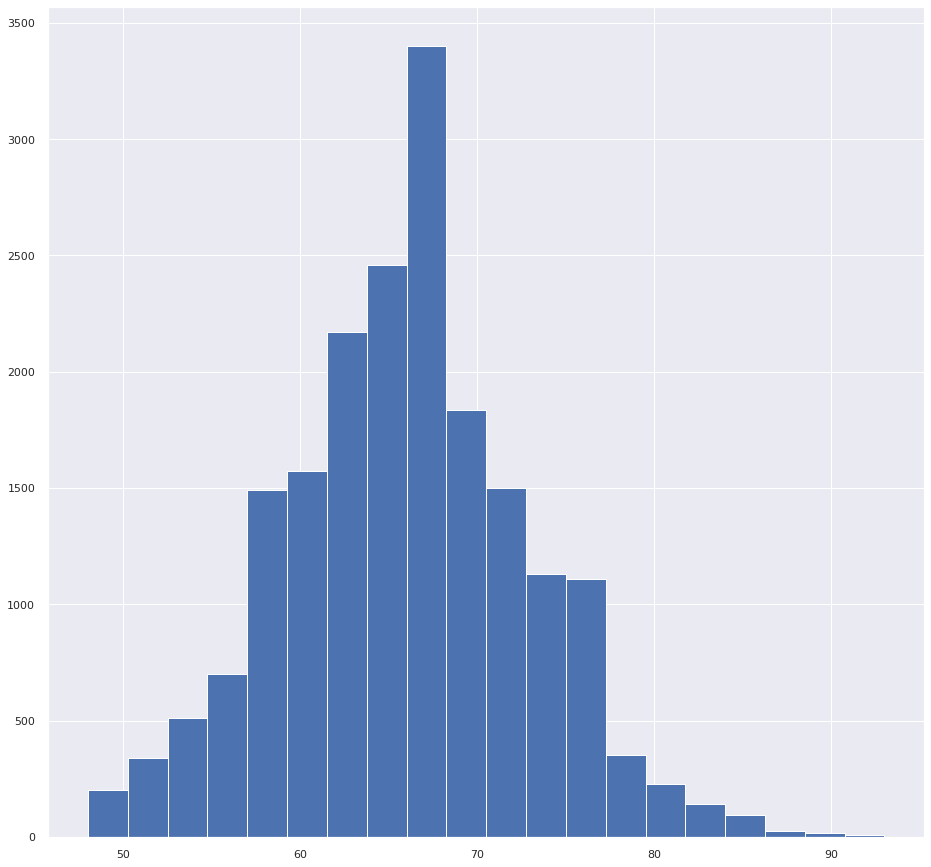

In [278]:
df['Overall'].hist(bins = 20)

In [279]:
pd.DataFrame(df.ClubPosition.value_counts().sort_index())

ClubPosition
CAM           328
CB           1582
CDM           630
CF              8
CM           1006
GK            696
LB            520
LF             30
LM            407
LW            193
LWB           117
RB            519
RES          3182
RF             30
RM            411
RW            192
RWB           116
ST            924
SUB          8293

Agrupamos las posiciones en 4: arqueros, defensores, mediocampistas, delanteros. Las posiciones "SUB" y "RES" no está claro qué representan, por lo que lo manejaremos como una categoría aparte y luego analizaremos a qué corresponden y si son relevantes de utilizar.

In [280]:
df.dropna(subset = ["ClubPosition"], inplace=True)

In [281]:
def get_position(row):
    if (row['ClubPosition'] == "CDM") | (row['ClubPosition'] == "LB") | (row['ClubPosition'] == "LWB") | (row['ClubPosition'] == "RB")  | (row['ClubPosition'] == "RWB") | (row['ClubPosition'] == "CB") :
        val = 'Defensor'
    elif ( (row['ClubPosition'] == "CM") | (row['ClubPosition'] == "LM") | (row['ClubPosition'] == "RM") | (row['ClubPosition'] == "CAM") ):
        val = 'Mediocampista'
    elif ((row['ClubPosition'] == "LW") | (row['ClubPosition'] == "LF") | (row['ClubPosition'] == "RW") | (row['ClubPosition'] == "RF") | (row['ClubPosition'] == "CF") | (row['ClubPosition'] == "ST") ):
      val = 'Delantero'
    elif (row['ClubPosition'] == "GK"):
      val = 'Arquero'
    elif (row['ClubPosition'] == "SUB"):
      val = 'SUB'
    elif (row['ClubPosition'] == "RES"):
      val = 'RES'
    return val

df_n=df[(df['Overall'] > 75)] # mejores jugadores
df_n['Position'] = df_n.apply(get_position, axis=1)

In [282]:
print(f'{len(df_n)} mejores jugadores con overall mayor a 75')

skills_ratings = ['PaceTotal', 'ShootingTotal',
                  'PassingTotal', 'DribblingTotal', 'DefendingTotal', 'PhysicalityTotal',
                  'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
                  'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                  'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 'Balance',
                  'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots',
                  'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties',
                  'Composure', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
                  'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes']

print(f'{len(skills_ratings)} variables numéricas de desempeño según habilidad')

df_skills=df_n[skills_ratings]



1457 mejores jugadores con overall mayor a 75
40 variables numéricas de desempeño según habilidad


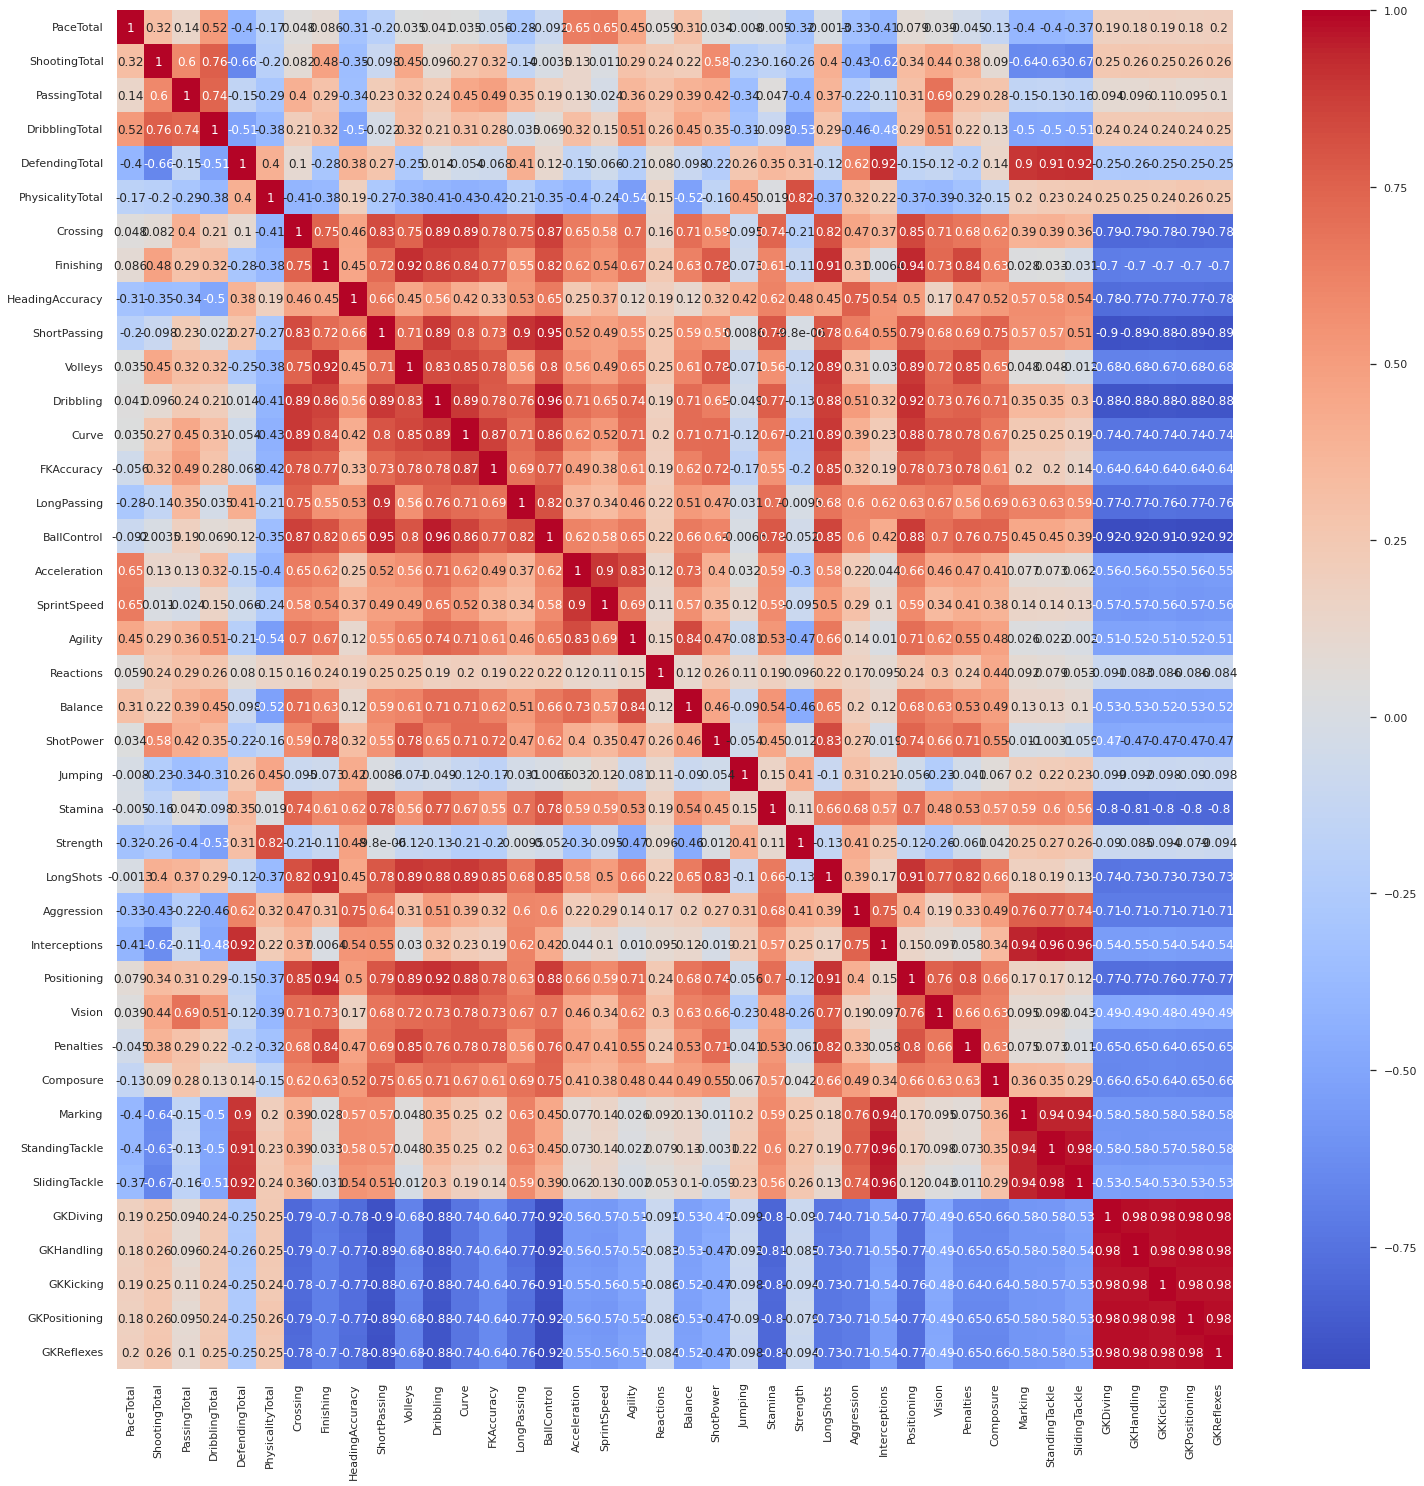

In [283]:
#Using Pearson Correlation
plt.figure(figsize=(25,25))
cor = df_skills.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.coolwarm)
plt.show()

Mucha información puede sacarse de la correlación entre las variables de habilidad del dataset. Muchas están estrechamente relacionadas, por lo que utilizar una implica tener información sobre la otra, esto será importante para elegir las variables en el entrenamiento del modelo. También se puede ver con claridad que las skills "GK" tienen correlación alta solo con 

In [284]:
club_avg_overall=df.groupby("Club")["Overall"].mean().reset_index().sort_values("Overall",ascending=False)
club_avg_overall.head(8)

Club    Overall
368             Juventus  79.961538
470  Paris Saint-Germain  79.454545
358                Inter  78.724138
241    FC Bayern München  78.107143
412    Manchester United  78.000000
509       Real Madrid CF  77.757576
434               Napoli  77.500000
63              Atalanta  77.480000

### Visualización de Características de los jugadores

In [285]:
for i in range(len(skills_ratings)):
    print(i,skills_ratings[i])

0 PaceTotal
1 ShootingTotal
2 PassingTotal
3 DribblingTotal
4 DefendingTotal
5 PhysicalityTotal
6 Crossing
7 Finishing
8 HeadingAccuracy
9 ShortPassing
10 Volleys
11 Dribbling
12 Curve
13 FKAccuracy
14 LongPassing
15 BallControl
16 Acceleration
17 SprintSpeed
18 Agility
19 Reactions
20 Balance
21 ShotPower
22 Jumping
23 Stamina
24 Strength
25 LongShots
26 Aggression
27 Interceptions
28 Positioning
29 Vision
30 Penalties
31 Composure
32 Marking
33 StandingTackle
34 SlidingTackle
35 GKDiving
36 GKHandling
37 GKKicking
38 GKPositioning
39 GKReflexes


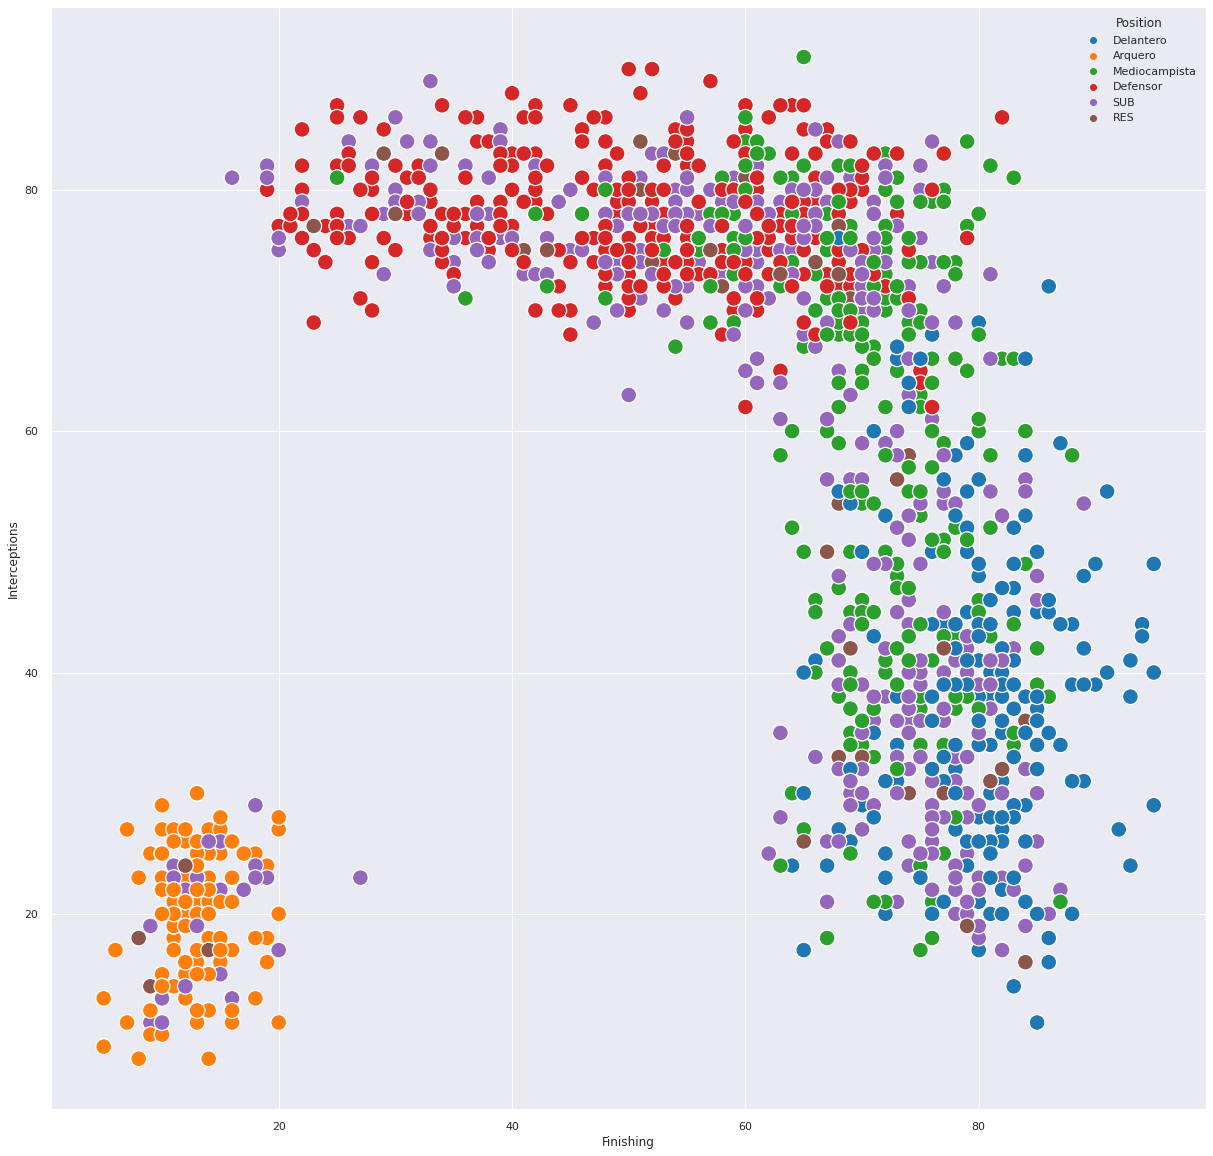

In [286]:
sns.set(rc={'figure.figsize':(20.7,20.27)})
#bool_crack=df_n["Overall"] > 85 #diferenciamos a los mejores jugadores

skill_1=skills_ratings[7]
skill_2=skills_ratings[27]

sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_n, s=250,palette="tab10")


Como podemos observar, las posiciones "SUB" y "RES" no tienen un grupo definido. Gracias a este análisis se puede inferir que SUB corresponde a "substitution" y RES a "jugador de reserva". Esto tiene sentido porque jugadores de reserva y suplentes están en todas las posiciones.

In [287]:
df_wo_sub_res = df_n[-( (df_n.Position == 'SUB') | (df_n.Position == 'RES'))]
df_skills=df_wo_sub_res[skills_ratings]
#bool_crack=df_n["Overall"] > 85 #diferenciamos a los mejores jugadores

skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_wo_sub_res, s=250,palette="tab10")

Podemos observar como se diferencian, con estas skills, los arqueros del resto de los jugadores (tienen valores bajos en las dos cosas). Luego, puede observarse que defensores y delanteros están bien separados. En cambio, los mediocampistas están mezclados entre todos los datos.

In [288]:
pairs_skills = [[9,14], [15,24], [34,9], [2,39]]

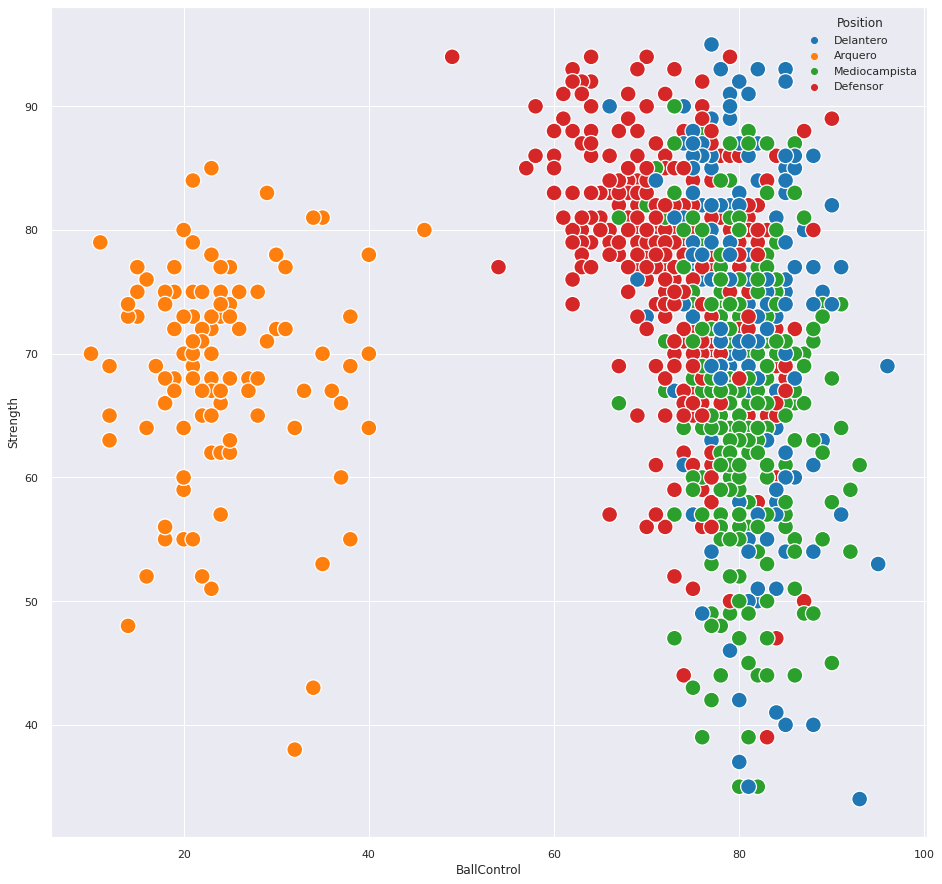

In [289]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
for i in pairs_skills:
  skill_1=skills_ratings[i[0]]
  skill_2=skills_ratings[i[1]]
  sns.scatterplot(x=skill_1,y=skill_2, hue='Position',data=df_wo_sub_res, s=250,palette="tab10")
  plt.show()

En estos casos se pueden ver:  
1. Una correlación positiva de variables en el primer gráfico entre pasos cortos y largos (jugadores que pasan bien en general, tienen alto este valor)  
2. y 3. Otras variables a tener en cuenta para poder separar mediocampistas de los otros grupos.
4. Los arqueros son fácilmente separables usando las estadísticas de GK.

### Entrenamiento de Modelo de K Medias

Normalización de los datos

In [290]:
std_scale = preprocessing.MinMaxScaler().fit_transform(df_skills.values)
df_skills = pd.DataFrame(std_scale)

Es necesario definirle la cantidad de grupos/clusters (n_clusters), es un hiperparámetro del algoritmo.

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

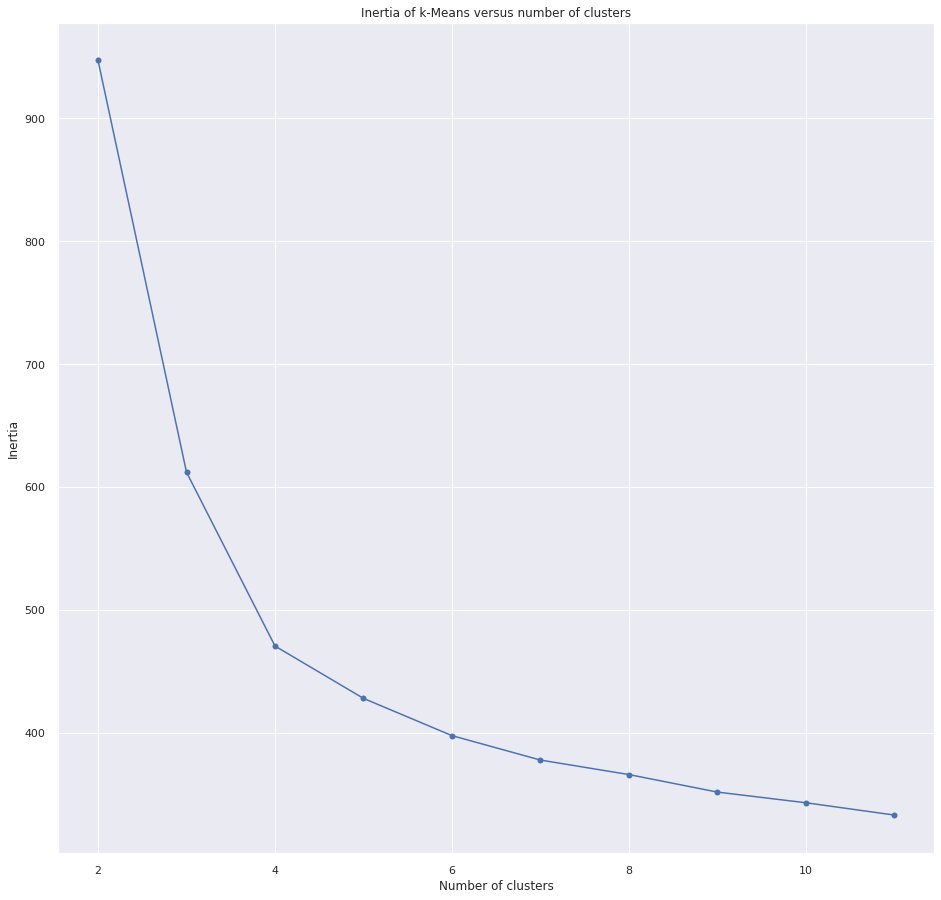

In [291]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i+2).fit(df_skills).inertia_ for i in range(10)]

from matplotlib import pyplot as plt
plt.plot(np.arange(2, 12), scores,'bo-')
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [292]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, random_state=42)
km.fit(df_skills)

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  470.70412091104134


In [293]:
df_clusters=df_wo_sub_res.copy()
df_clusters['kmeans'] = km.labels_ #clusters
print('Kmeans encontró: ', max(km.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('kmeans').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


kmeans
0    326
1    117
2    181
3    364
dtype: int64

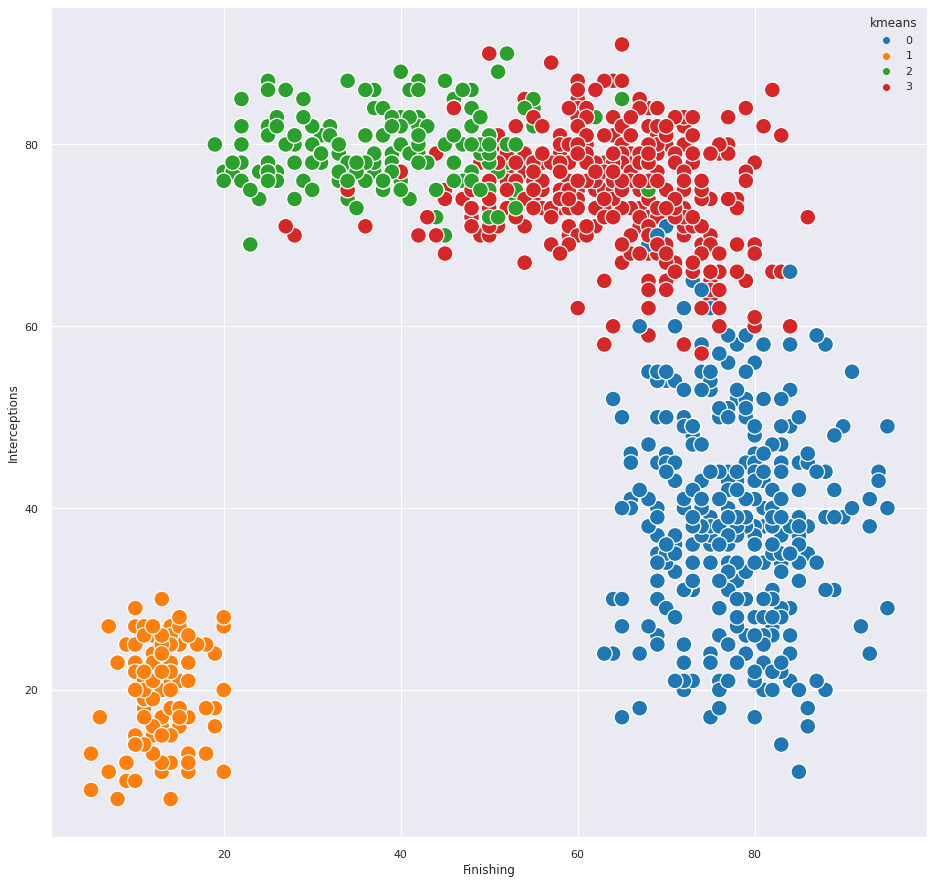

In [294]:
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='kmeans',data=df_clusters, s=250,palette="tab10")

Tomamos ejemplos de cada cluster

In [295]:
best_players_per_cluster=df_clusters.iloc[df_clusters.groupby(df_clusters['kmeans'])['Overall'].idxmax()][['kmeans','Name','ClubPosition','Overall']]
best_players_per_cluster

kmeans          Name ClubPosition  Overall
0        0      L. Messi           RW       93
4        1      J. Oblak           GK       91
16       2   V. van Dijk           CB       89
5        3  K. De Bruyne           CM       91

Calculamos las métricas de este modelo

In [296]:
codes = {0:'Delantero', 1:'Arquero', 2:'Defensor',3:'Mediocampista'}

In [297]:
df_clusters['kmeans'] = df_clusters['kmeans'].map(codes)

In [298]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
from sklearn import metrics


def statistics_model(labels, model_labels):
  metricas = (metrics.homogeneity_score(labels, model_labels),
              metrics.completeness_score(labels, model_labels),
              metrics.v_measure_score   (labels, model_labels)) 
  print('Homogeneidad:\t%.3f\nCompletitud:\t%.3f\nV Measure:\t%.3f'%(metricas[0],metricas[1],metricas[2]))

  return metricas

metricas_km = statistics_model(df_clusters['ClubPosition'],df_clusters['kmeans'])

Homogeneidad:	0.395
Completitud:	0.752
V Measure:	0.518


In [299]:
from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_skills)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f79a1e2de50>,
                     model=None)

### Spectral Clustering

In [300]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(
    n_clusters=4,
    eigen_solver=None,
    n_components=None,
    random_state=42,
    n_init=4,
    gamma=0.1,
    affinity='rbf',
    n_neighbors=4,
    eigen_tol=0.0,
    assign_labels='kmeans',
    degree=3,
    coef0=1,
    kernel_params=None,
    n_jobs=None)

In [301]:
sc.fit(df_skills)
# Recuperacion de etiquetas
clusters = sc.labels_

In [302]:
df_clusters['sc'] = sc.labels_ #clusters
print('Kmeans encontró: ', max(sc.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('sc').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


sc
0    167
1    117
2    418
3    286
dtype: int64

In [303]:
best_players_per_cluster=df_clusters.iloc[df_clusters.groupby(df_clusters['sc'])['Overall'].idxmax()][['sc','Name','ClubPosition','Overall']]
best_players_per_cluster

sc          Name ClubPosition  Overall
46   3     J. Sancho           LM       87
4    1      J. Oblak           GK       91
5    2  K. De Bruyne           CM       91
0    3      L. Messi           RW       93

In [304]:
codes = {0:'Defensor', 1:'Arquero', 2:'Mediocampista',3:'Delantero'}

In [305]:
df_clusters['sc'] = df_clusters['sc'].map(codes)

In [306]:
sns.set(rc={'figure.figsize':(15.7,15.27)})
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='sc',data=df_clusters, s=250,palette="tab10")

In [307]:
metricas_sc = statistics_model(df_clusters['ClubPosition'],df_clusters['sc'])

Homogeneidad:	0.375
Completitud:	0.726
V Measure:	0.494


In [308]:
for i in range(1):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df_skills) + (n_clust + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sc
    cluster_labels = clusters

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df_skills, cluster_labels)
    print("Para n_clusters =", n_clust,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_skills, cluster_labels)

    y_lower = 10
    for i in range(n_clust):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / n_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("Valor del coeficiente silhouette")
    ax1.set_ylabel("Cluster Id")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

Para n_clusters = 4 El silhouette_score promedio es : 0.33802412665723186


### Descomposición PCA

In [309]:
from sklearn import decomposition
pca=decomposition.PCA(n_components=2) #elegimos 2, 3 o 4 pero pueden ser más, 

pca.fit(df_skills) #input data is centered but not scaled for each feature before applying the SVD

# proporción de varianza
print('proporción de varianza por componente: ', pca.explained_variance_ratio_)
# proporción de varianza acumulada
print ('proporción de varianza por componente acumulada: ', pca.explained_variance_ratio_.cumsum())

X_projected=pca.transform(df_skills) #numpy array
print ('tamaño de los datos: ', X_projected.shape)

proporción de varianza por componente:  [0.54411957 0.2317167 ]
proporción de varianza por componente acumulada:  [0.54411957 0.77583627]
tamaño de los datos:  (988, 2)


In [310]:
# Número de clusters buscado
n_clust = 4

km_pca = KMeans(n_clusters=n_clust)
km_pca.fit(X_projected)

# Recuperacion de etiquetas
clusters = km_pca.labels_
print('Suma de los cuadrados de las distancias al cluster / Inertia: ', km_pca.inertia_)

Suma de los cuadrados de las distancias al cluster / Inertia:  86.39943534860986


In [311]:
df_clusters=df_wo_sub_res.copy()
df_clusters['kmeans_pca'] = km_pca.labels_ #clusters
print('Kmeans encontró: ', max(km_pca.labels_)+1, 'clusters, nosotros lo forzamos')

df_clusters.groupby('kmeans_pca').size()

Kmeans encontró:  4 clusters, nosotros lo forzamos


kmeans_pca
0    180
1    117
2    341
3    350
dtype: int64

In [312]:
skill_1=skills_ratings[7]
skill_2=skills_ratings[27]
sns.scatterplot(x=skill_1,y=skill_2, hue='kmeans_pca',data=df_clusters, s=250,palette="tab10")

In [313]:
metricas_km_pca = statistics_model(df_clusters['ClubPosition'],df_clusters['kmeans_pca'])

from yellowbrick.cluster import SilhouetteVisualizer

visualizer = SilhouetteVisualizer(km_pca, colors='yellowbrick')
visualizer.fit(df_skills)


Homogeneidad:	0.398
Completitud:	0.759
V Measure:	0.523


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f79a1c56f50>,
                     model=None)

### Comparación Modelos

In [314]:
print(metricas_km_pca)
print(metricas_km)
print(metricas_sc)

(0.39844424848313537, 0.7589942362366209, 0.5225623513521829)
(0.39473711033875286, 0.7521318465305411, 0.5177476466076368)
(0.3746950990140472, 0.7259103685365527, 0.4942644125136917)


### Conclusión

Claramente a través de la descomposición PCA pudimos mejorar considerablemente el resultado de la clusterización del modelo. Esto se puede observar tanto en las métricas como en las siluetas.  
Lo planteado en la introducción fue probado. Pueden clusterizarse por posición en la cancha a los jugadores según sus características. Lo más difícil es separar a los mediocampistas de delanteros y defensores, pero a través de las técnicas vistas en clases, puede encontrarse un modelo que de buenos resultados.  
Más barridos de los hiperparámetros pueden realizarse para obtener un modelo más refinado e incrementar las métricas del mismo.